<a href="https://colab.research.google.com/github/ilovesounds/devandaisubmission/blob/main/AIandDevsubmission2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy


In [2]:
import pandas


In [3]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/behaviour_simulation_train.xlsx")


df.shape
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                300000 non-null  int64 
 1   date              300000 non-null  object
 2   likes             300000 non-null  int64 
 3   content           300000 non-null  object
 4   username          300000 non-null  object
 5   media             300000 non-null  object
 6   inferred company  300000 non-null  object
dtypes: int64(2), object(5)
memory usage: 16.0+ MB


,0
id,0
date,0
likes,0
content,0
username,0
media,0
inferred company,0


In [4]:
df.dropna(subset=['content', 'username', 'inferred company', 'likes'], inplace=True)
df['media'] = df['media'].fillna('no_media')


df['has_media'] = df['media'].apply(lambda x: x != 'no_media')
df['content'] = df['content'].astype(str).str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['date'], errors='coerce')

In [5]:
print(df.columns.tolist())
print(len(df))



['id', 'date', 'likes', 'content', 'username', 'media', 'inferred company', 'has_media', 'datetime']
300000


<Axes: xlabel='likes', ylabel='Count'>

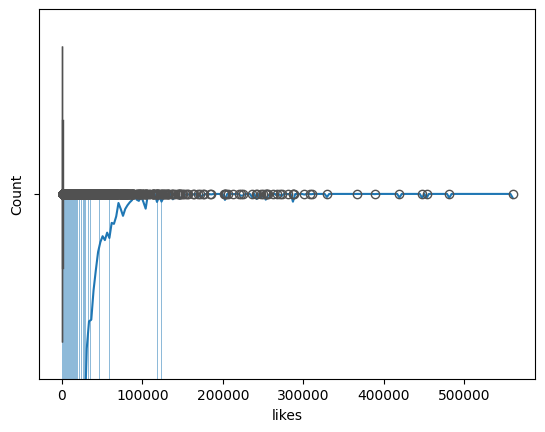

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['likes'], kde=True)
sns.boxplot(x=df['likes'])

In [7]:
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.day_name()
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
df['char_count'] = df['content'].apply(len)

In [8]:
from textblob import TextBlob

df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [9]:
df['char_count'] = df['content'].apply(len)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['company_encoded'] = le.fit_transform(df['inferred company'])

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['company_encoded'] = le.fit_transform(df['inferred company'])

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['day_of_week_encoded'] = le.fit_transform(df['day_of_week'])

In [13]:
print(df.columns.tolist())
print(len(df))

['id', 'date', 'likes', 'content', 'username', 'media', 'inferred company', 'has_media', 'datetime', 'hour', 'day_of_week', 'word_count', 'char_count', 'sentiment', 'company_encoded', 'day_of_week_encoded']
300000


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
from math import sqrt
import numpy as np

# Use log1p to handle zeros safely (log1p(x) = log(x + 1))
y = np.log1p(df['likes'])


X = df[['word_count', 'char_count',  'hour', 'sentiment','company_encoded','day_of_week_encoded']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict in log scale
log_preds = model.predict(X_test)

# Convert predictions back to original scale
preds = np.expm1(log_preds)


# Calculate the mean of y_train (average likes in training data)
# Inverse transform y_test
y_test_original = np.expm1(y_test)

# Calculate RMSE in the original scale
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test_original, preds)
print("RMSE (original scale):", sqrt(rmse))


# Calculate RMSE for the baseline
y_mean_log = y_train.mean()
baseline_log_preds = [y_mean_log] * len(y_test)
baseline_preds = np.expm1(baseline_log_preds)
baseline_rmse = mean_squared_error(y_test_original, baseline_preds)
print("Baseline RMSE (Mean Prediction, original scale):", sqrt(baseline_rmse))
import joblib
joblib.dump(model, 'like_predictor.pkl')



RMSE (original scale): 4506.889372331521
Baseline RMSE (Mean Prediction, original scale): 4881.240219298552


['like_predictor.pkl']

In [17]:
!pip install flask  # Remove outdated versions
!pip install pyngrok==7.0.0 flask-ngrok  # Install compatible versions
!ngrok authtoken 2yLrIIDJhRxrbgX2AHj01gBqQny_2jKfv8K9xNnjMjt4cKXR  # Replace with your free ngrok token



Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [24]:

!pip install flask pyngrok==7.0.0  # Install dependencies first
from flask import Flask, request, jsonify
import joblib
import numpy as np
from pyngrok import ngrok
import threading

# Load model
model = joblib.load('like_predictor.pkl')

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print(" * ngrok tunnel:", public_url)

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = np.array([
        data['word_count'],
        data['char_count'],
        data['hour'],
        data['sentiment'],
        data['company_encoded'],
        data['day_of_week_encoded']
    ]).reshape(1, -1)
    prediction = model.predict(features)[0]
    return jsonify({'predicted_likes': int(prediction)})

def run_flask():
    app.run(host='0.0.0.0', port=5000)

# Start Flask in background thread
flask_thread = threading.Thread(target=run_flask)
flask_thread.daemon = True  # Daemonize thread
flask_thread.start()




 * ngrok tunnel: NgrokTunnel: "https://b410-34-41-61-190.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'


In [29]:
import requests

url = "http://127.0.0.1:5000/predict"  # Local testing within Colab
data = {
    "word_count": 100,
    "char_count": 500,
    "hour": 14,
    "sentiment": 0.8,
    "company_encoded": 1,
    "day_of_week_encoded": 3
}
response = requests.post(url, json=data)
print(response.json())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [11/Jun/2025 08:18:28] "POST /predict HTTP/1.1" 200 -


{'predicted_likes': 0}
